   • Below are the sample solutions for all the questions.<br>
   • You may compare the work which you have accomplished with the sample solution provided to share your observations with          us or make changes to your craft.<br>
   • The summary statistics are spread across different questions. You may calculate the summary statistics for every question, as suggested in the assignment question.

## Problem I - Backtests a strategy using three moving averages on any indices such as Nifty50, SPY, HSI and so on.

- Compute three moving averages of 20, 40, and 80.
- Go long when the price crosses above all three moving averages.
- Exit the long position when the price crosses below any of the three moving averages.
- Go short when the price crosses below all three moving averages.
- Exit the short position when the price crosses above any of the three moving averages.
- Optional: Optimize all three moving averages

In [15]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [16]:
def download_data(stock, start, end):
    data = yf.download(stock, start, end)
    return data

In [17]:
def generate_returns(stock):
    data['p_returns'] = data['Close'].pct_change()
    return data

In [18]:
def backtest_strategy(df, sma, mma, lma, print_chart):
    data = df.copy()

    data['sma'] = data['Close'].rolling(window=sma).mean()
    data['mma'] = data['Close'].rolling(window=mma).mean()
    data['lma'] = data['Close'].rolling(window=lma).mean()

    # Method 1
    # Generating long entry signals
    # Go long when the price crosses above all three moving averages
    data['signal'] = np.where((data['Close'] > data['sma']) &
                              (data['Close'] > data['mma']) &
                              (data['Close'] > data['lma']), 1, 0)

    # Generating long exit signals
    # Exit the long position when the price crosses below any of the three moving averages
    data['signal'] = np.where((data['Close'] < data['sma']) |
                              (data['Close'] < data['mma']) |
                              (data['Close'] < data['lma']), 0, data['signal'])

    # Generating short entry signals
    # Go short when the price crosses below all three moving averages
    data['signal'] = np.where((data['Close'] < data['sma']) &
                              (data['Close'] < data['mma']) &
                              (data['Close'] < data['lma']), -1, data['signal'])

    # Generating short exit signals
    # Exit the short position when the price crosses above any of the three moving averages
    data['signal'] = np.where((data['Close'] > data['sma']) |
                              (data['Close'] > data['mma']) |
                              (data['Close'] > data['lma']), 0, data['signal'])

    if print_chart == True:
        data[['signal', 'sma', 'lma', 'Close']].iloc[50:130].plot(
            figsize=(10, 6), secondary_y='signal')

    data['strategy_returns'] = data['p_returns'] * data['signal'].shift(1)

    return data

In [19]:
def calculate_returns(data):
    bnh = (data['p_returns']+1).cumprod()[-1]
    s_returns = (data['strategy_returns']+1).cumprod()[-1]

    return bnh, s_returns

[*********************100%***********************]  1 of 1 completed
Buy and hold returns: 1.67
Strategy returns: 0.95


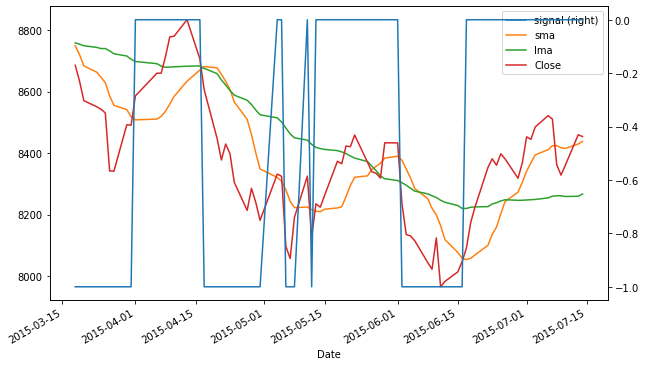

In [20]:
data = download_data('^NSEI', '2015-1-1', '2020-12-31')
data = generate_returns(data)
data = backtest_strategy(data, 10, 20, 30, True)

bnh, s_returns = calculate_returns(data)

print('Buy and hold returns:', np.round(bnh, 2))
print('Strategy returns:', np.round(s_returns, 2))

Start date,2015-01-02
End date,2020-12-30
Total months,70
,Backtest
Annual return,-0.945%
Cumulative returns,-5.393%
Annual volatility,13.579%
Sharpe ratio,-0.00
Calmar ratio,-0.04
Stability,0.43
Max drawdown,-26.875%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.87,2020-03-23,2020-09-30,NaT,NaN
1,25.12,2016-02-11,2020-02-19,2020-03-18,1070
2,7.07,2015-04-30,2015-08-19,2015-09-02,90
3,5.83,2020-03-19,2020-03-20,2020-03-23,3
4,4.39,2015-09-07,2015-09-29,2015-12-08,67


Stress Events,mean,min,max
Fall2015,0.17%,-2.02%,5.92%
New Normal,-0.00%,-8.76%,12.98%


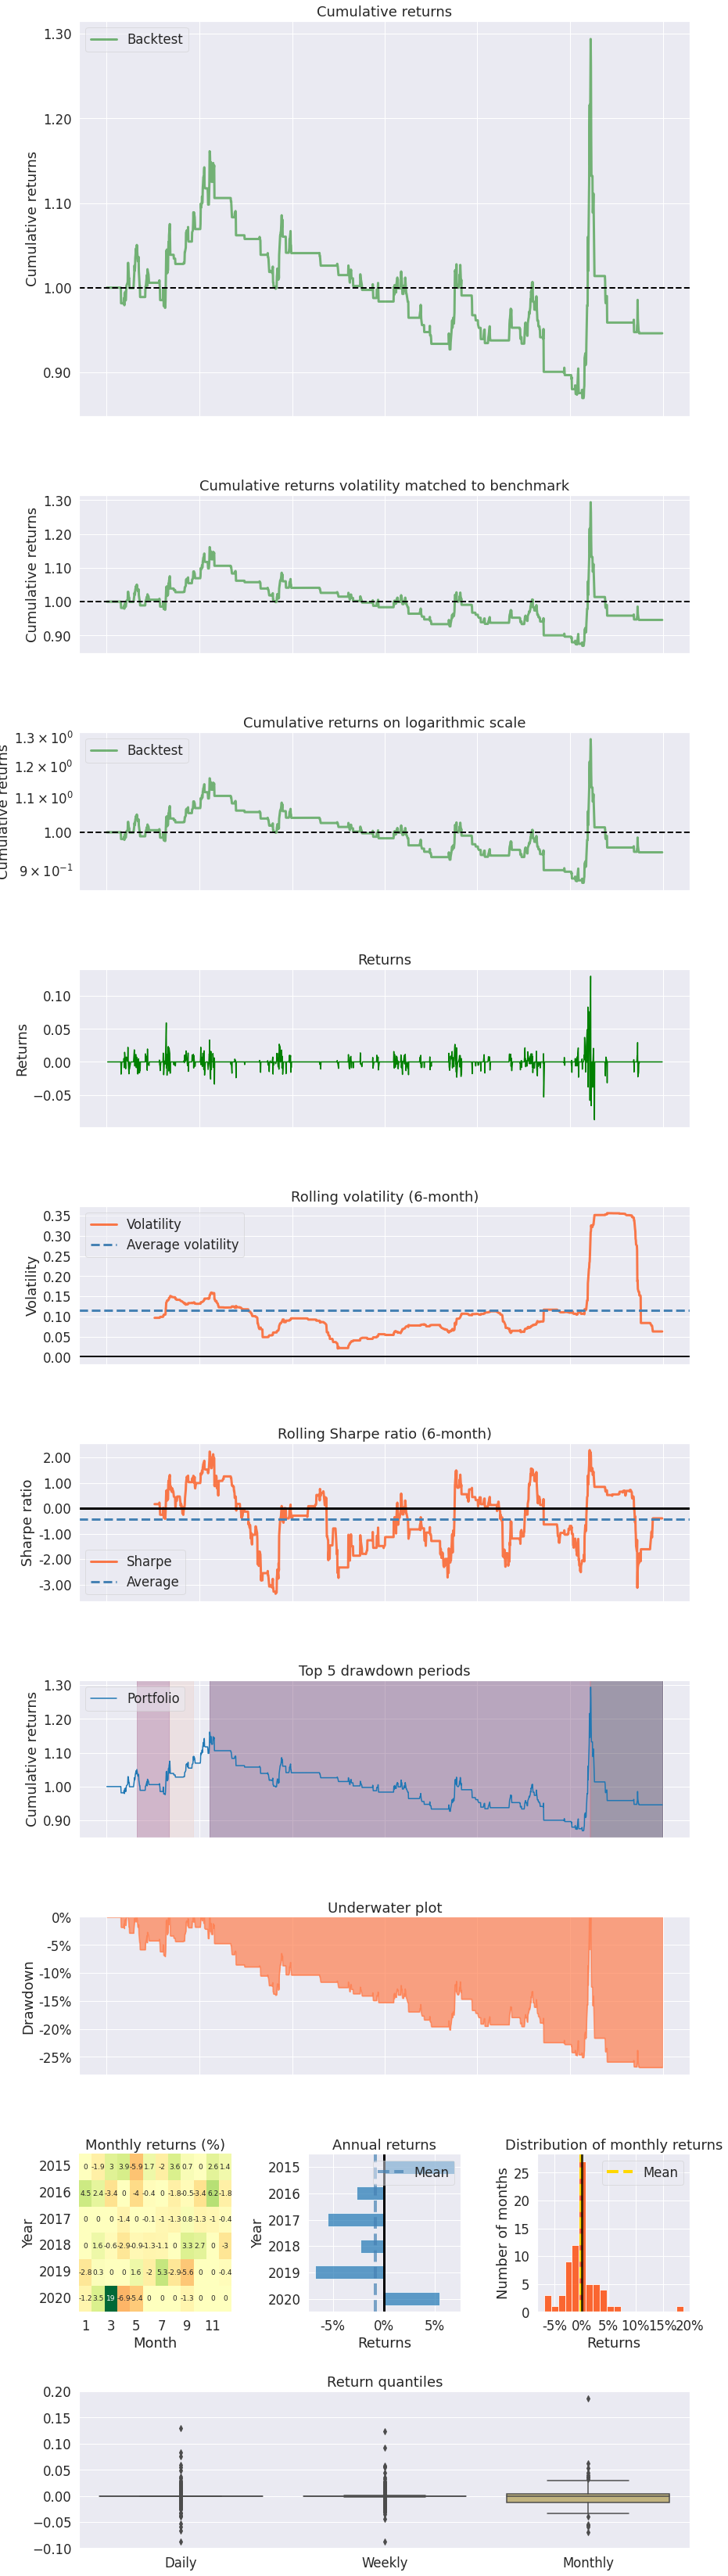

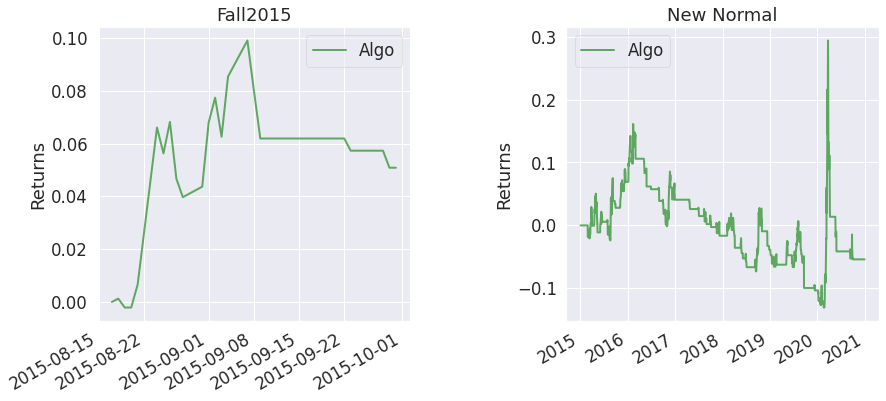

In [21]:
# Get the summary statistics for the strategy using pyfolio
import pyfolio as pf

pf.create_full_tear_sheet(data['strategy_returns'])

In [22]:
data = download_data('^NSEI', '2015-1-1', '2020-12-31')
ma_dict = {}

# Optimize the strategy
for sma in range(30, 40, 5):
    for mma in range(60, 75, 5):
        for lma in range(100, 115, 5):
            key = 'sma'+str(sma)+'_mma'+str(mma)+'_lma'+str(lma)
            print(f'\nChecking for SMA: {sma}, MMA: {mma}, LMA: {lma}')
            df = data.copy()
            df = data = generate_returns(df)
            df = backtest_strategy(df, sma, mma, lma, False)
            bnh, s_returns = calculate_returns(df)
            print('Buy and hold returns:', np.round(bnh, 2))
            print('Strategy returns:', np.round(s_returns, 2))
            ma_dict[key] = s_returns
else:
    print('Computation Completed.')

# Print the sma, mma, lma values that yield the max strategy returns
max_ret = max(ma_dict.values())
opt_values = [key for key, value in ma_dict.items() if value == max_ret]
print(f"The max strategy returns are {max_ret} for the values {opt_values}.")

[*********************100%***********************]  1 of 1 completed

Checking for SMA: 30, MMA: 60, LMA: 100
Buy and hold returns: 1.67
Strategy returns: 1.1

Checking for SMA: 30, MMA: 60, LMA: 105
Buy and hold returns: 1.67
Strategy returns: 1.1

Checking for SMA: 30, MMA: 60, LMA: 110
Buy and hold returns: 1.67
Strategy returns: 1.1

Checking for SMA: 30, MMA: 65, LMA: 100
Buy and hold returns: 1.67
Strategy returns: 1.1

Checking for SMA: 30, MMA: 65, LMA: 105
Buy and hold returns: 1.67
Strategy returns: 1.1

Checking for SMA: 30, MMA: 65, LMA: 110
Buy and hold returns: 1.67
Strategy returns: 1.1

Checking for SMA: 30, MMA: 70, LMA: 100
Buy and hold returns: 1.67
Strategy returns: 1.09

Checking for SMA: 30, MMA: 70, LMA: 105
Buy and hold returns: 1.67
Strategy returns: 1.09

Checking for SMA: 30, MMA: 70, LMA: 110
Buy and hold returns: 1.67
Strategy returns: 1.1

Checking for SMA: 35, MMA: 60, LMA: 100
Buy and hold returns: 1.67
Strategy returns: 1.13

Checking for SMA: 35, MMA: 

## Problem II - Buy and sell the next day
- Buy the stock on the fourth day open, if the stock closes down consecutively for three days.
- Exit on the next day open.
- Optional: Optimize the strategy by exiting the long position on the same day close.

Also, you can optimize the number of down days. There are high chances that the number of down days would be different for each stock.

In [23]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
df = yf.download('TSLA', start='2010-1-1', end='2020-03-31')

[*********************100%***********************]  1 of 1 completed


In [25]:
data = df.copy()

In [26]:
# Create open to open returns
data['oo_returns'] = np.log(data['Open'] / data['Open'].shift(1))

# Create close to close returns
data['cc_returns'] = np.log(data['Close'] / data['Close'].shift(1))

# Generating trading signals
# Day 1 = Down day
# Day 2 = Down day
# Day 3 = Down day
# Day 4 = Buy at open
data['signals'] = np.where((data['cc_returns'].shift(1) < 0) &
                           (data['cc_returns'].shift(2) < 0) &
                           (data['cc_returns'].shift(3) < 0), 1, 0)

# To give the effect of buying on the next day open
data['signals'] = data['signals'].shift(1)

# Compute strategy returns
data['strategy_returns'] = data['signals'].shift(1) * data['oo_returns']

# Print returns
print('Buy and hold returns: ', np.round(data['cc_returns'].cumsum()[-1], 2))
print('Strategy returns: ', np.round(data['strategy_returns'].cumsum()[-1], 2))

Buy and hold returns:  3.05
Strategy returns:  0.88


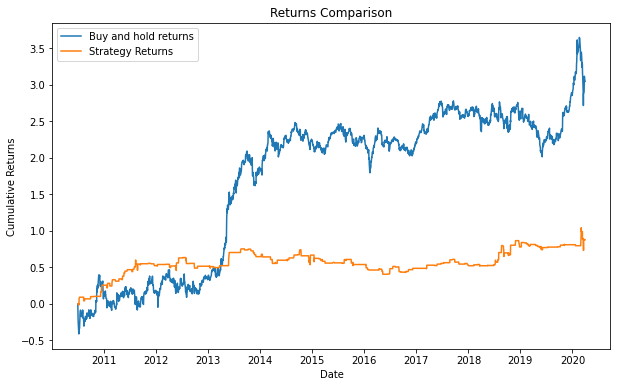

In [27]:
bnh = data['cc_returns'].cumsum()
s_returns = data['strategy_returns'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(bnh, label='Buy and hold returns')
plt.plot(s_returns, label='Strategy Returns')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.title('Returns Comparison')
plt.legend()
plt.show()

Start date,2010-06-29
End date,2020-03-30
Total months,116
,Backtest
Annual return,7.649%
Cumulative returns,105.046%
Annual volatility,18.232%
Sharpe ratio,0.49
Calmar ratio,0.24
Stability,0.24
Max drawdown,-31.436%


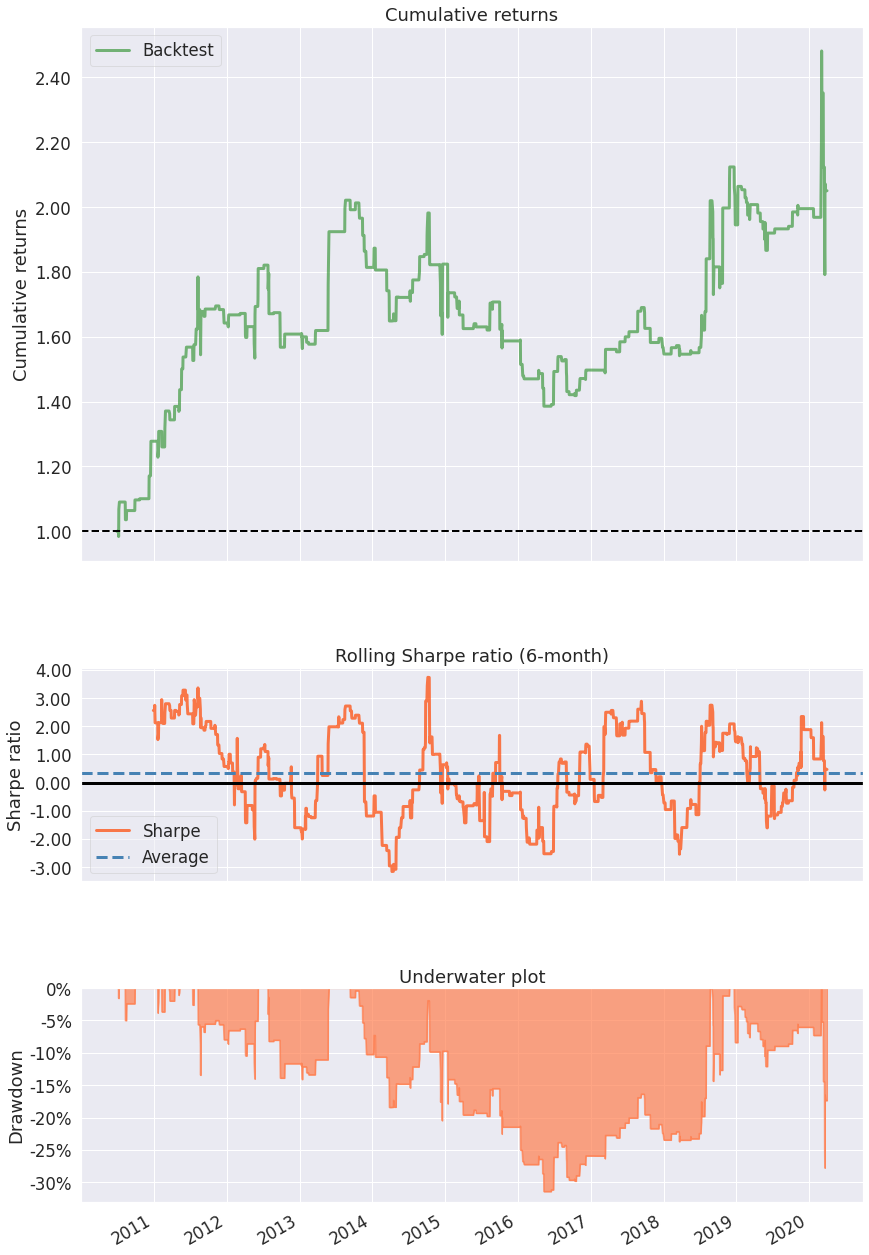

In [28]:
# Get the summary statistics for the strategy using pyfolio
pf.create_simple_tear_sheet(data['strategy_returns'])

## Problem III - Strategy based on RSI indicator.
1. Buy the instrument such as Nifty or SPY when the RSI is less than 30
2. Exit conditions:
    a. Take profit of 5% or RSI > 70,
    b. Stop loss of - 2%
3. Optional: Optimize the strategy by adjusting the RSI value. Also, take profit and stop loss criteria can be different for each stock.
4. Note: You can use TA-Lib in Python to compute the RSI value.

In [29]:
# Importing the necessary libraries
import talib
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline


# start date
start = datetime.datetime(2010, 2, 25)
# end date
end = datetime.datetime(2020, 2, 25)


# Getting data from SPY (SPR S&P500 ETF)
df1 = pdr.get_data_yahoo('SPY', start, end)

**Data preprocessing**

In [30]:
# Making a copy to work with
SPY = df1.copy()

# Data cleaning, dropping unnecessary columns
SPY.drop(['High', 'Low', 'Open', 'Close', 'Volume'], axis=1, inplace=True)

# Calculating RSI using talib
SPY['RSI'] = talib.RSI(SPY['Adj Close'])

# Dropping NaN values and resetting the index(this will help in data manipulation)
SPY.dropna(inplace=True, axis=0)
SPY = SPY.reset_index()

SPY.head()

,Date,Adj Close,RSI
0,2010-03-16,92.332169,97.453506
1,2010-03-17,92.879417,97.738764
2,2010-03-18,92.831856,96.724644
3,2010-03-19,92.361977,87.108575
4,2010-03-22,92.855743,88.412278


**Defining a function for backtesting, based on the conditions mentioned in the question statement**

In [31]:
def backtesting_RSI(df, TP_level, SL_level):
    '''
    This function backtests the following RSI strategy:

    - Entry condition:
      Buy the instrument when the RSI is less than 30

    - Exit conditions: 
      a. Take profit level is hit or
      b. RSI > 70 or
      c. Stop loss level is hit

    This function takes in three arguments:

    df: The DataFrame containing daily stock data (in a Yahoo finance format) along with the 14 day RSI column

    TP_level: Take profit level in percent

    SL_level: Stop loss level in percent

    Note: You can add other summary metrics such as Sharpe ratio, Max DD etc. to this function 

    '''

    # Initializing two new columns
    df['entry_price'] = 0
    df['RSI_signal'] = 0

    # Defining a few variables to generate signals using a for-loop (similar to Q1 of DMP 01)
    n = df.shape[0]
    cash = 1
    stock = 0

    # The for-loop to create signals based on RSI only
    for i in range(0, n):

        if df['RSI'].loc[i] <= 30 and cash == 1:
            df['RSI_signal'].loc[i] = 1
            df['entry_price'].loc[i] = df['Adj Close'].loc[i]

            cash = 0
            stock = 1

        if stock == 1 and df['RSI'].loc[i] >= 70:
            df['RSI_signal'].loc[i] = -1
            cash = 1
            stock = 0

    # Creating columns for take profit and stop loss prices, based on the trade entry price
    df['take_profit_price'] = df['entry_price']*(1 + TP_level)
    df['stop_loss_price'] = df['entry_price']*(1 - SL_level)

    df['take_profit_price'] = df['take_profit_price'].replace(
        to_replace=0, method='ffill')
    df['stop_loss_price'] = df['stop_loss_price'].replace(
        to_replace=0, method='ffill')

    # Updating the signal taking into account TP and SL
    for i in range(0, n):

        # if in a position based on previous conditions and if Adj Close breaches TP or SL, make the signal -1
        if df['Adj Close'].loc[i] < df['stop_loss_price'].loc[i] or df['Adj Close'].loc[i] > df['take_profit_price'].loc[i]:
            df['RSI_signal'].loc[i] = -1

    # forward filling the signals so that we can get the position column from it later
    df['RSI_signal'] = df['RSI_signal'].replace(to_replace=0, method='ffill')

    # For position column,  replacing -1 with 0, as this is a long only strategy
    df['position'] = df['RSI_signal'].replace(to_replace=-1, value=0)

    # Visualizing the strategy with position overlaid on RSI
    y = df['RSI'].plot(figsize=(30, 10))
    l1 = np.array([30 for i in range(n)])
    l2 = np.array([70 for i in range(n)])
    plt.plot(l1)
    plt.plot(l2)
    df['position'].plot(ax=y, secondary_y='position')
    plt.title('Visualizing the strategy with position overlaid on RSI')
    plt.show()

    # Calculating and plotting strategy returns
    df['daily_log_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift())
    df['strategy_returns'] = df['daily_log_returns']*df['position'].shift()
    df['cumulative_strategy_returns'] = np.cumsum(df['strategy_returns'])
    print('total return from this strategy:', df['strategy_returns'].sum())
    df['cumulative_strategy_returns'].plot()
    plt.title('Cumulative returns for this strategy')
    plt.show()

    return df

**Using the function to backtest the strategy on the SPY data with**
* TP level set at 5% or 0.05 and
* SL level at 2% or 0.02

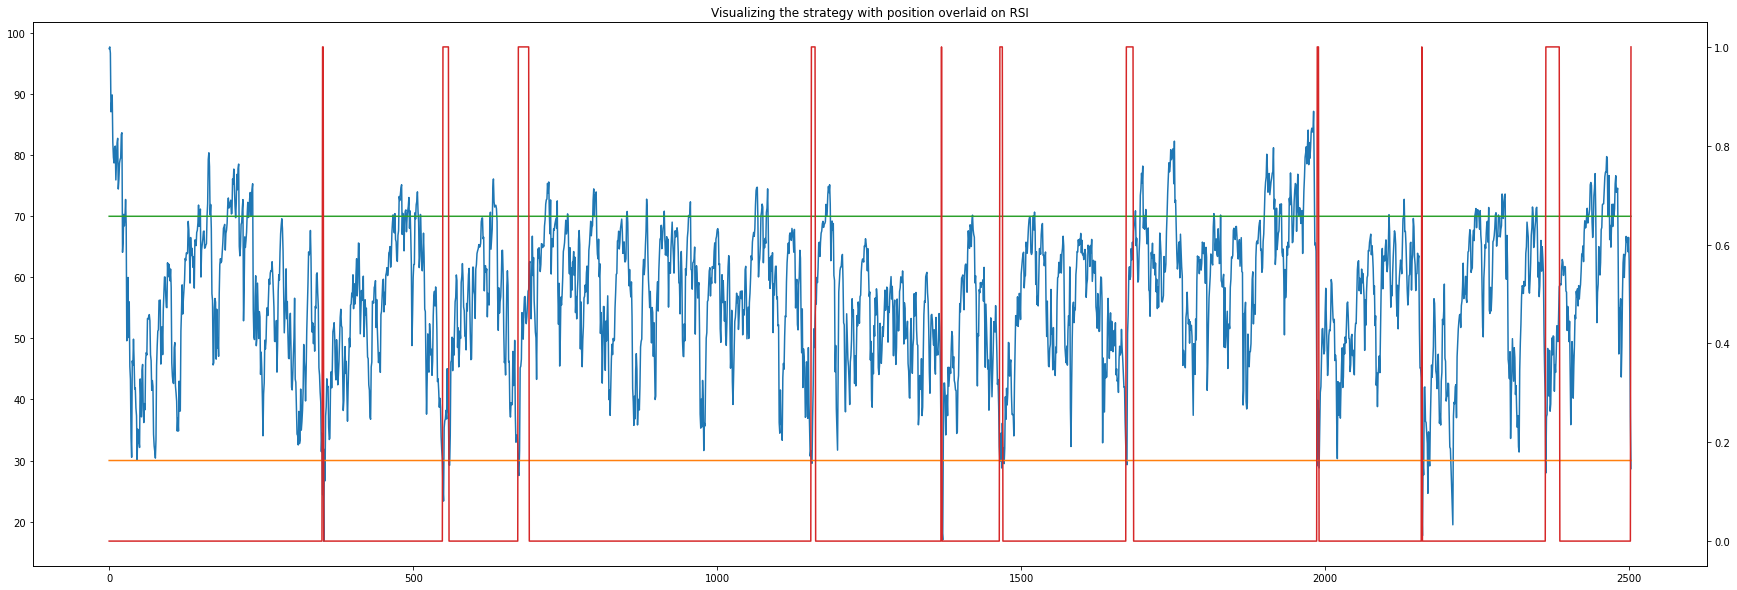

total return from this strategy: 0.007190155730456914


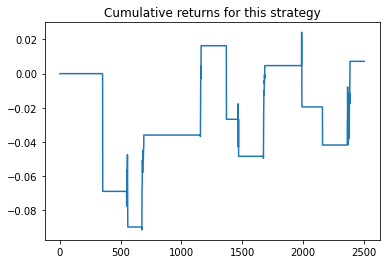

In [32]:
df_rsi = backtesting_RSI(SPY, TP_level=0.05, SL_level=0.02)

## Problem IV - Backtest the strategy based on the turtle trading system covered in EFS-02 class.

You can use the daily data for backtesting purpose. Also, the event-driven approach covered in DMP-01 and DMP-03 would be best for this scenario.

In [33]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import talib as ta
import pyfolio as pf

In [34]:
# setup
symbol = 'MSFT'
start = '2018-01-01'
end = '2019-12-31'
source = 'yahoo'
ndays_high = 3
ndays_low = 3
nATR = 20
SL = 1  # Stop loss: number of ATR to stop loss
TP = 2  # Take profit: number of ATR to take profit
equity = 10000

# retrieving data from Yahoo
df = web.DataReader(symbol, source, start, end)
df.tail(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-27,159.550003,158.220001,159.449997,158.960007,18412800.0,155.986176
2019-12-30,159.020004,156.729996,158.990005,157.589996,16348400.0,154.641785
2019-12-31,157.770004,156.449997,156.770004,157.699997,18369400.0,154.749756


In [35]:
# Compute the ATR indicator
df['ATR'] = ta.ATR(high=df.High, low=df.Low,
                   close=df.Close, timeperiod=nATR).shift(1)
df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,ATR
Date,,,,,,,
2019-12-24,157.710007,157.119995,157.479996,157.380005,8989200.0,154.435730,1.764806
2019-12-26,158.729996,157.399994,157.559998,158.669998,14520600.0,155.701584,1.706066
2019-12-27,159.550003,158.220001,159.449997,158.960007,18412800.0,155.986176,1.688262
2019-12-30,159.020004,156.729996,158.990005,157.589996,16348400.0,154.641785,1.670349
2019-12-31,157.770004,156.449997,156.770004,157.699997,18369400.0,154.749756,1.701332


In [36]:
# Drop the na required to compute the ATR
df.dropna(inplace=True)

In [37]:
# Compute the moving last n highest high and lowest low
df['ndays_high'] = df['High'].rolling(ndays_high).max().shift(1)
df['ndays_low'] = df['Low'].rolling(ndays_low).min().shift(1)
df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,ATR,ndays_high,ndays_low
Date,,,,,,,,,
2019-12-24,157.710007,157.119995,157.479996,157.380005,8989200.0,154.435730,1.764806,158.490005,153.750000
2019-12-26,158.729996,157.399994,157.559998,158.669998,14520600.0,155.701584,1.706066,158.490005,156.289993
2019-12-27,159.550003,158.220001,159.449997,158.960007,18412800.0,155.986176,1.688262,158.729996,157.119995
2019-12-30,159.020004,156.729996,158.990005,157.589996,16348400.0,154.641785,1.670349,159.550003,157.119995
2019-12-31,157.770004,156.449997,156.770004,157.699997,18369400.0,154.749756,1.701332,159.550003,156.729996


In [38]:
# Run strategy
df['signal'] = ""
df['position'] = 0
df['trade_price'] = 0
df['trade_ret'] = 0

for i in range(0, len(df)):

    # If there is an open position carry the position and the entry price
    if df.iloc[i-1].position != 0:
        print(i, str(df.index[i]), "Carry position")
        df.position.iloc[i] = df.iloc[i-1].position
        df.trade_price.iloc[i] = df.iloc[i-1].trade_price

    # Entry long
    if df.iloc[i].High > df.iloc[i].ndays_high and df.iloc[i].position == 0:
        print(i, str(df.index[i]), "Entry long, price", df.iloc[i].Close)
        df.position.iloc[i] = 1
        df.trade_price.iloc[i] = df.iloc[i].Open
        df.signal.iloc[i] = "Entry long"

    # Check take profit and stop loss for long position
    elif df.iloc[i].position == 1:
        if df.iloc[i].Close > df.iloc[i].trade_price + df.iloc[i].ATR * TP:
            print(i, str(df.index[i]),
                  "Take profit long, price", df.iloc[i].Close)
            df.position.iloc[i] = 0
            df.trade_ret.iloc[i] = df.iloc[i].Open / df.iloc[i].trade_price - 1
            df.trade_price.iloc[i] = df.iloc[i].Open
            df.signal.iloc[i] = "TP long"
        elif df.iloc[i].Close < df.iloc[i].trade_price - df.iloc[i].ATR * SL:
            print(i, str(df.index[i]),
                  "Stop loss short, price", df.iloc[i].Close)
            df.position.iloc[i] = 0
            df.trade_ret.iloc[i] = df.iloc[i].Open / df.iloc[i].trade_price - 1
            df.trade_price.iloc[i] = df.iloc[i].Open
            df.signal.iloc[i] = "SL long"

    # Entry short
    elif df.iloc[i].Low < df.iloc[i].ndays_low and df.iloc[i].position == 0:
        print(i, str(df.index[i]), "Entry short, price", df.iloc[i].Close)
        df.position.iloc[i] = -1
        df.trade_price.iloc[i] = df.iloc[i].Open
        df.signal.iloc[i] = "Entry short"

    # Check take profit and stop loss for short position
    elif df.iloc[i].position == -1:
        if df.iloc[i].Close < df.iloc[i].trade_price - df.iloc[i].ATR * TP:
            print(i, str(df.index[i]),
                  "Take profit short, price", df.iloc[i].Close)
            df.position.iloc[i] = 0
            df.trade_ret.iloc[i] = df.iloc[i].trade_price / df.iloc[i].Open - 1
            df.trade_price.iloc[i] = df.iloc[i].Open
            df.signal.iloc[i] = "TP short"
        elif df.iloc[i].Close > df.iloc[i].trade_price + df.iloc[i].ATR * SL:
            print(i, str(df.index[i]),
                  "Stop loss short, price", df.iloc[i].Close)
            df.position.iloc[i] = 0
            df.trade_ret.iloc[i] = df.iloc[i].trade_price / df.iloc[i].Open - 1
            df.trade_price.iloc[i] = df.iloc[i].Open
            df.signal.iloc[i] = "SL short"

3 2018-02-06 00:00:00 Entry short, price 91.33000183105469
4 2018-02-07 00:00:00 Carry position
4 2018-02-07 00:00:00 Stop loss short, price 89.61000061035156
5 2018-02-08 00:00:00 Entry short, price 85.01000213623047
6 2018-02-09 00:00:00 Carry position
7 2018-02-12 00:00:00 Carry position
8 2018-02-13 00:00:00 Carry position
9 2018-02-14 00:00:00 Carry position
10 2018-02-15 00:00:00 Carry position
10 2018-02-15 00:00:00 Stop loss short, price 92.66000366210938
11 2018-02-16 00:00:00 Entry long, price 92.0
12 2018-02-20 00:00:00 Carry position
13 2018-02-21 00:00:00 Carry position
14 2018-02-22 00:00:00 Carry position
15 2018-02-23 00:00:00 Carry position
16 2018-02-26 00:00:00 Carry position
17 2018-02-27 00:00:00 Carry position
18 2018-02-28 00:00:00 Carry position
19 2018-03-01 00:00:00 Carry position
20 2018-03-02 00:00:00 Carry position
21 2018-03-05 00:00:00 Carry position
22 2018-03-06 00:00:00 Carry position
23 2018-03-07 00:00:00 Carry position
24 2018-03-08 00:00:00 Carry p

In [39]:
df.head(30)

,High,Low,Open,Close,Volume,Adj Close,ATR,ndays_high,ndays_low,signal,position,trade_price,trade_ret
Date,,,,,,,,,,,,,
2018-02-01,96.070000,93.580002,94.790001,94.260002,47227900.0,89.597794,1.447000,NaN,NaN,,0,0.000000,0.000000
2018-02-02,93.970001,91.500000,93.639999,91.779999,47867800.0,87.240448,1.499150,NaN,NaN,,0,0.000000,0.000000
2018-02-05,93.239998,88.000000,90.559998,88.000000,51031500.0,83.647446,1.562193,NaN,NaN,,0,0.000000,0.000000
2018-02-06,91.480003,85.250000,86.889999,91.330002,67998600.0,86.812721,1.746083,96.070000,88.000000,Entry short,-1,86.889999,0.000000
2018-02-07,91.769997,89.199997,90.489998,89.610001,41107600.0,85.177780,1.970279,93.970001,85.250000,SL short,0,90.489998,-0.039783
2018-02-08,89.879997,84.760002,89.709999,85.010002,55628700.0,80.805305,2.000265,93.239998,85.250000,Entry short,-1,89.709999,0.000000
2018-02-09,88.930000,83.830002,86.300003,88.180000,63499100.0,83.818512,2.156251,91.769997,84.760002,,-1,89.709999,0.000000
2018-02-12,89.779999,87.930000,88.739998,89.129997,35720300.0,84.721527,2.303439,91.769997,83.830002,,-1,89.709999,0.000000
2018-02-13,90.000000,87.800003,88.930000,89.830002,26407700.0,85.386909,2.280767,89.879997,83.830002,,-1,89.709999,0.000000


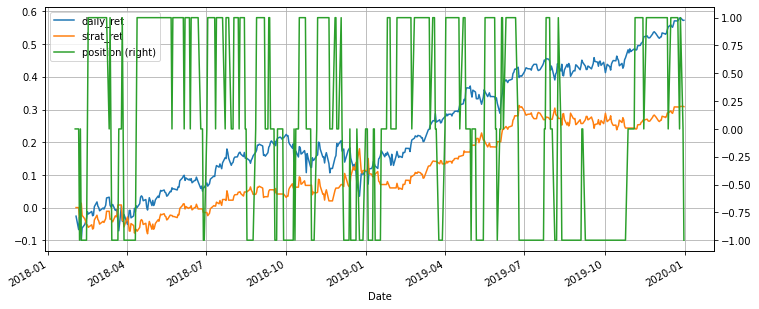

In [40]:
# compute the daily return (buy-and-hold returns)
df['daily_ret'] = df['Close'].pct_change()

# Compute the strategy returns
df['strat_ret'] = df['daily_ret'] * df['position']

# Plot returns
df2 = df[['daily_ret', 'strat_ret']].cumsum()
df2['position'] = df['position']
df2[['daily_ret', 'strat_ret', 'position']].plot(
    secondary_y='position', grid=True, figsize=(12, 5))

Start date,2018-02-01
End date,2019-12-31
Total months,22
,Backtest
Annual return,15.313%
Cumulative returns,31.328%
Annual volatility,19.494%
Sharpe ratio,0.83
Calmar ratio,1.26
Stability,0.91
Max drawdown,-12.147%


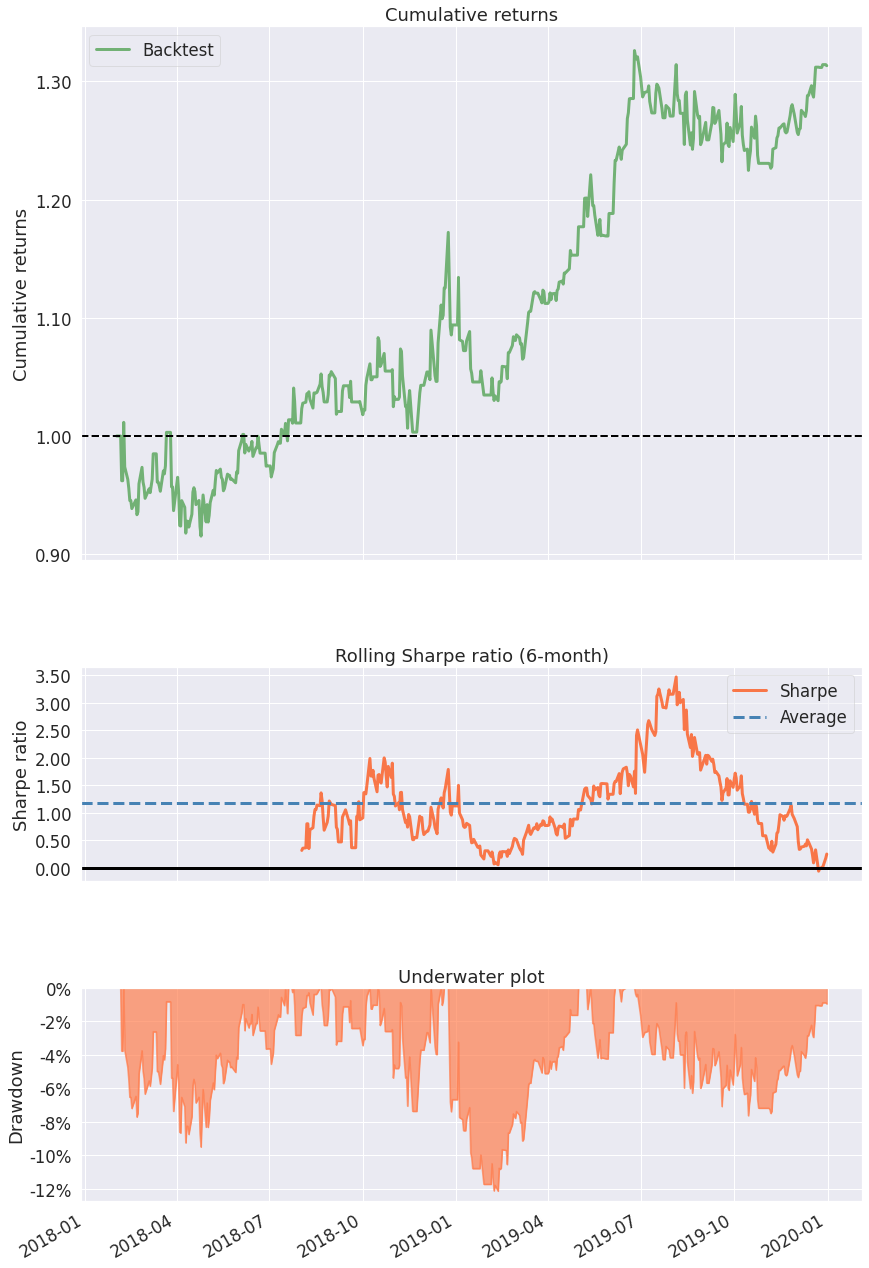

In [41]:
# Get the summary statistics for the strategy using pyfolio
pf.create_simple_tear_sheet(df['strat_ret'])

## Problem V - Backtest a strategy based on a high & low price

1. Go long when the stock closes above the last 20 day’s high price.
2. Square off the long position when the stock goes below the last 20 day’s low price.
3. Optional: Optimise the strategy by adjusting the number of periods. You can choose to have different number of periods for entering the long and exiting the long.

In [42]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import talib as ta
import pyfolio as pf

In [43]:
# setup
symbol = 'MSFT'
start = '2018-01-01'
end = '2019-12-31'
source = 'yahoo'
ndays_high = 20
ndays_low = 20
equity = 10000

# retrieving data from Yahoo
df = web.DataReader(symbol, source, start, end)
df.tail(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-27,159.550003,158.220001,159.449997,158.960007,18412800.0,155.986206
2019-12-30,159.020004,156.729996,158.990005,157.589996,16348400.0,154.641815
2019-12-31,157.770004,156.449997,156.770004,157.699997,18369400.0,154.749741


In [44]:
# Compute the moving last n highest high
df['ndays_high'] = df['High'].rolling(ndays_high).max().shift(1)
df['ndays_low'] = df['Low'].rolling(ndays_low).min().shift(1)
df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,ndays_high,ndays_low
Date,,,,,,,,
2019-12-24,157.710007,157.119995,157.479996,157.380005,8989200.0,154.435730,158.490005,146.649994
2019-12-26,158.729996,157.399994,157.559998,158.669998,14520600.0,155.701599,158.490005,146.649994
2019-12-27,159.550003,158.220001,159.449997,158.960007,18412800.0,155.986206,158.729996,146.649994
2019-12-30,159.020004,156.729996,158.990005,157.589996,16348400.0,154.641815,159.550003,146.649994
2019-12-31,157.770004,156.449997,156.770004,157.699997,18369400.0,154.749741,159.550003,146.649994


In [45]:
# Create a function to compute the signals
df['Signal'] = 0
df['Signal'] = np.where(df['Close'] > df['ndays_high'], 1, 0)
df['Signal'] = np.where(df['Close'] < df['ndays_low'], -1, df['Signal'])
df['Signal'] = df['Signal'].replace(0, np.nan).ffill()
df['Position'] = df['Signal'].replace(-1, 0).shift(1)
df.tail()

,High,Low,Open,Close,Volume,Adj Close,ndays_high,ndays_low,Signal,Position
Date,,,,,,,,,,
2019-12-24,157.710007,157.119995,157.479996,157.380005,8989200.0,154.435730,158.490005,146.649994,1.0,1.0
2019-12-26,158.729996,157.399994,157.559998,158.669998,14520600.0,155.701599,158.490005,146.649994,1.0,1.0
2019-12-27,159.550003,158.220001,159.449997,158.960007,18412800.0,155.986206,158.729996,146.649994,1.0,1.0
2019-12-30,159.020004,156.729996,158.990005,157.589996,16348400.0,154.641815,159.550003,146.649994,1.0,1.0
2019-12-31,157.770004,156.449997,156.770004,157.699997,18369400.0,154.749741,159.550003,146.649994,1.0,1.0


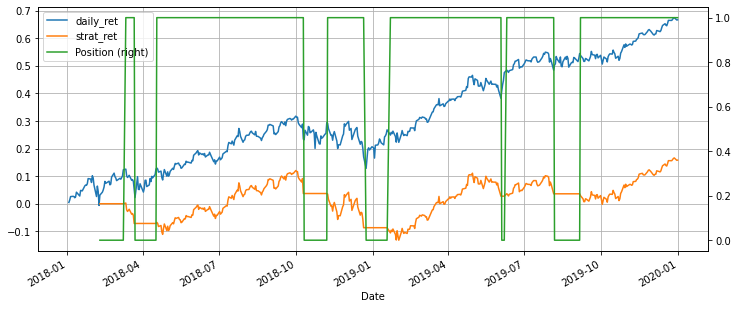

In [46]:
# compute the daily return (buy-and-hold returns)
df['daily_ret'] = df['Close'].pct_change()

# Compute the strategy returns
df['strat_ret'] = df['daily_ret'] * df['Position']

# Plot returns
df2 = df[['daily_ret', 'strat_ret']].cumsum()
df2['Position'] = df['Position']
df2[['daily_ret', 'strat_ret', 'Position']].plot(
    secondary_y='Position', grid=True, figsize=(12, 5))

Start date,2018-01-02
End date,2019-12-31
Total months,23
,Backtest
Annual return,6.629%
Cumulative returns,13.668%
Annual volatility,17.796%
Sharpe ratio,0.47
Calmar ratio,0.29
Stability,0.15
Max drawdown,-23.122%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.12,2018-10-01,2019-02-01,2019-12-16,316
1,10.84,2018-03-12,2018-04-25,2018-07-12,89
2,4.93,2018-07-25,2018-07-30,2018-08-29,26
3,3.67,2018-08-31,2018-09-07,2018-09-13,10
4,1.47,2018-09-14,2018-09-19,2018-09-20,5


Stress Events,mean,min,max
New Normal,0.03%,-5.43%,3.71%


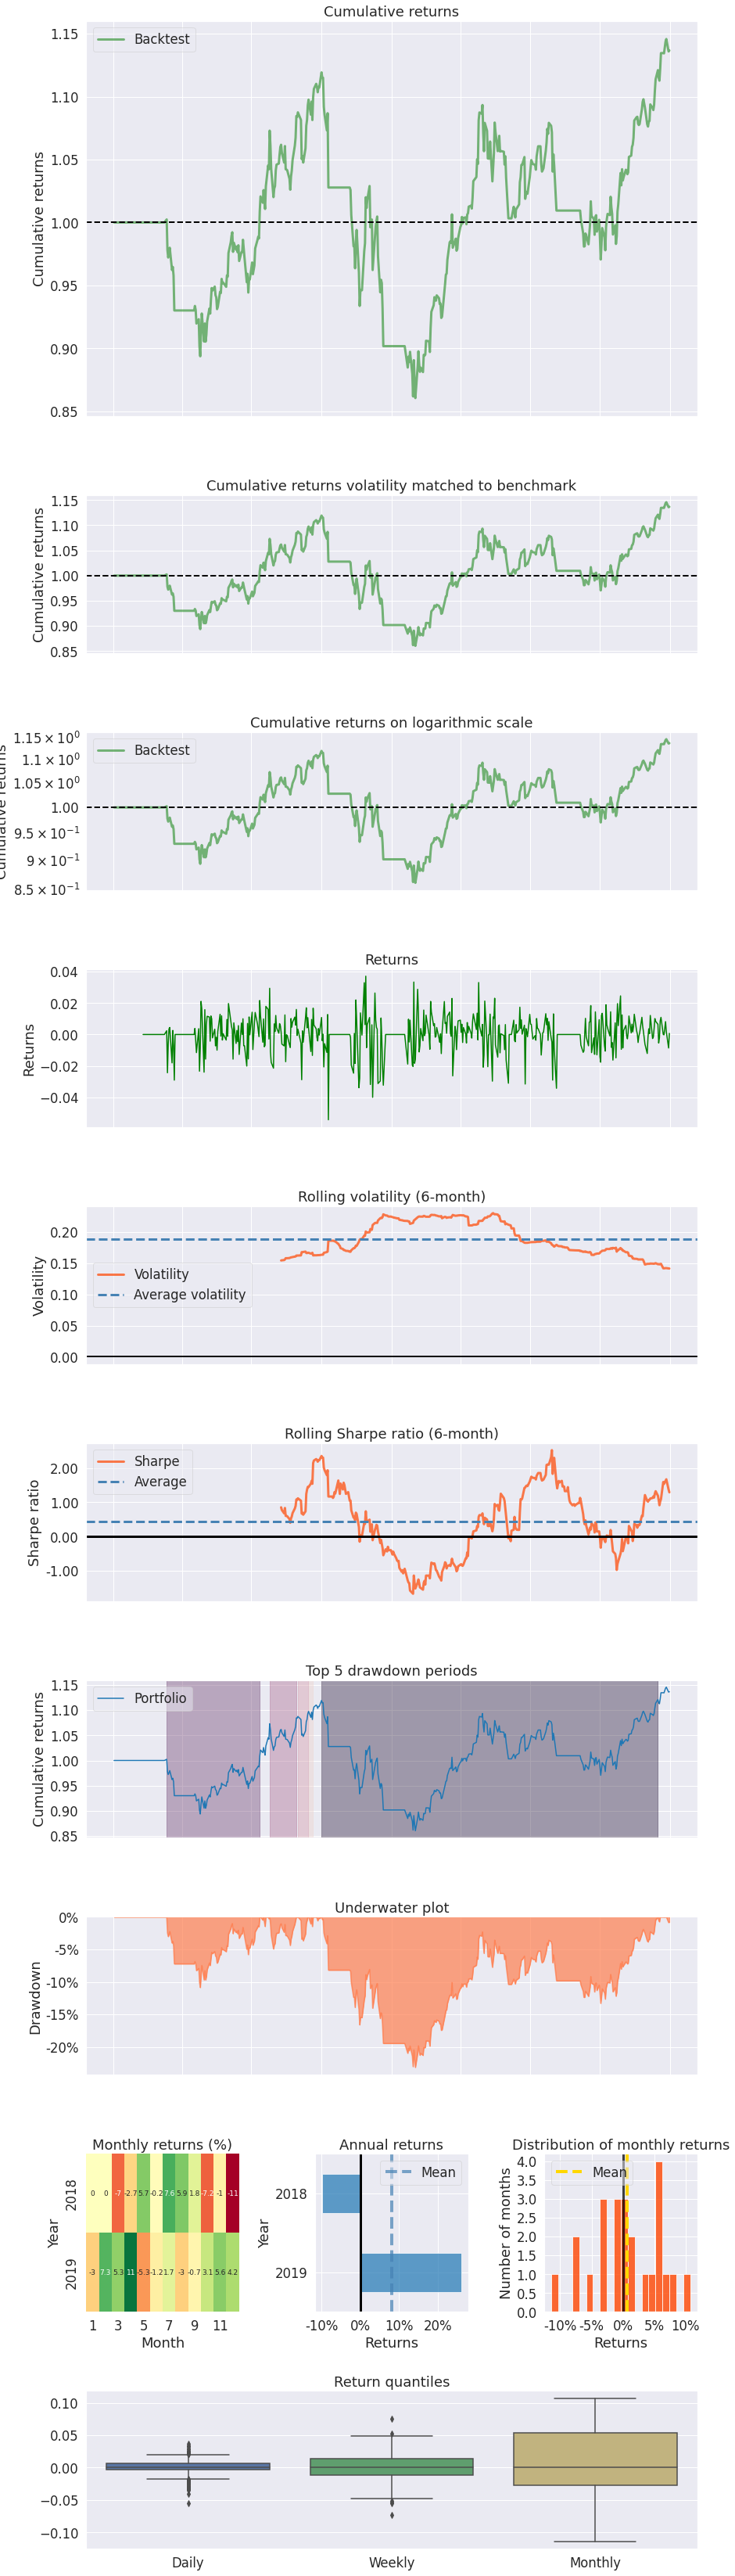

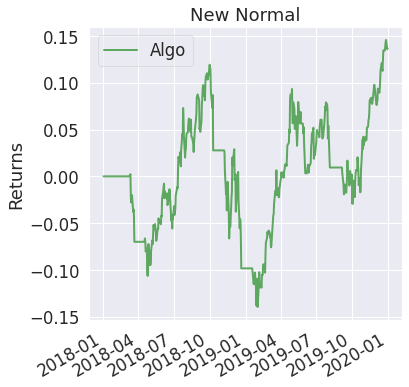

In [47]:
# Get the summary statistics for the strategy using pyfolio
pf.create_full_tear_sheet(df['strat_ret'])